In [68]:
# imports
import numpy as np 
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import cross_val_score

from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import precision_recall_curve, auc, roc_curve

In [69]:
# read file
df = pd.read_csv("telecom_churn.csv")

#dat preperation
y = df.Churn
X = df.drop("Churn", axis=1)

X_trainval, X_test, y_trainval, y_test = train_test_split(X, y ,test_size=0.2, random_state=5)

X_train, X_valid, y_train, y_valid = train_test_split(X_trainval, y_trainval, test_size=0.2, random_state=5)

# Feature

In [70]:
clf = DecisionTreeClassifier(random_state=5)
cross_val_score(clf, X_train, y_train, cv=7)

array([0.90819672, 0.8852459 , 0.86557377, 0.86885246, 0.84868421,
       0.88486842, 0.875     ])

In [71]:
clf.fit(X_train, y_train)
print(accuracy_score(y_valid, clf.predict(X_valid)))

0.8726591760299626


In [72]:
clf.feature_importances_

array([0.07302401, 0.07284572, 0.04529514, 0.04957783, 0.08978838,
       0.26332763, 0.05836769, 0.04702324, 0.18166278, 0.11908758])

In [73]:
def sortSecond(val):
    return val[1]
values = clf.feature_importances_
features = list(X)
importances = [(features[i], values[i]) for i in range(len(features))]
importances.sort(reverse=True, key=sortSecond)
importances

[('DayMins', 0.2633276326588507),
 ('OverageFee', 0.18166278096485472),
 ('RoamMins', 0.11908757611946662),
 ('CustServCalls', 0.08978837632765888),
 ('AccountWeeks', 0.07302401302668503),
 ('ContractRenewal', 0.07284571977565822),
 ('DayCalls', 0.058367687648731514),
 ('DataUsage', 0.04957783438473902),
 ('MonthlyCharge', 0.04702324304685946),
 ('DataPlan', 0.04529513604649586)]

In [74]:
print ('All features:', X_train.memory_usage(index=True).sum()/1000000)
print ('Top 15 features:', X_train[[col[0] for col in importances[:5]]].memory_usage(index=True).sum()/1000000)

All features: 0.187616
Top 15 features: 0.102336


In [75]:
X_train_cut = X_train[[col[0] for col in importances[:5]]]
X_valid_cut = X_valid[[col[0] for col in importances[:5]]]
cut_clf = DecisionTreeClassifier(random_state=5)
cut_clf.fit(X_train_cut, y_train)
print(accuracy_score(y_valid, cut_clf.predict(X_valid_cut)))

0.8689138576779026


In [76]:
X_test_cut = X_test[[col[0] for col in importances[:5]]]

print(classification_report(y_test, cut_clf.predict(X_test_cut)))

              precision    recall  f1-score   support

           0       0.92      0.90      0.91       575
           1       0.45      0.50      0.47        92

    accuracy                           0.85       667
   macro avg       0.68      0.70      0.69       667
weighted avg       0.85      0.85      0.85       667




confusion matrix for tree(max_depth 4) after upsamling:
[[518  57]
 [ 46  46]]


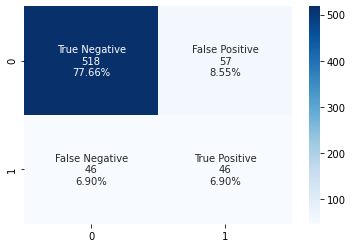

In [77]:
confusion_tree=confusion_matrix(y_test,  cut_clf.predict(X_test_cut))
print("\nconfusion matrix for tree(max_depth 4) after upsamling:\n{}".format(confusion_tree))

group_names = ["True Negative","False Positive","False Negative","True Positive"]
group_counts = ["{0:0.0f}".format(value) for value in
                confusion_tree.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     confusion_tree.flatten()/np.sum(confusion_tree)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns_plot = sns.heatmap(confusion_tree, annot=labels, fmt="", cmap='Blues')

# Tuning Hyparameters

In [78]:
from sklearn.model_selection import RepeatedStratifiedKFold

cv_method = RepeatedStratifiedKFold(n_splits=10, 
                                    n_repeats=3, 
                                    random_state=5)

In [79]:
from sklearn.tree import DecisionTreeClassifier

df_classifier = DecisionTreeClassifier(random_state=5)

params_DT = {'criterion': ['gini', 'entropy'],
                  'splitter': ['best', 'random'],
                  'max_depth': [1, 2, 3, 4, 5, 6, 7, 8],
                  'max_features': [1, 2, 3, 4, 5 ,6],
                 'min_samples_split': [2, 3, 4]}

gs_DT = GridSearchCV(estimator=df_classifier, 
                     param_grid=params_DT, 
                     cv=cv_method,
                     n_jobs=-1,
                     verbose=1, 
                     scoring='accuracy')

gs_DT.fit(X_train, y_train);

Fitting 30 folds for each of 576 candidates, totalling 17280 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 2536 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 10536 tasks      | elapsed:    7.7s
[Parallel(n_jobs=-1)]: Done 17280 out of 17280 | elapsed:   12.9s finished


In [80]:
best_tuned_clf = gs_DT.best_estimator_

In [81]:
print(accuracy_score(y_valid, best_tuned_clf.predict(X_valid)))

0.9288389513108615


In [82]:
print(classification_report(y_test, best_tuned_clf.predict(X_test)))

              precision    recall  f1-score   support

           0       0.94      0.98      0.96       575
           1       0.82      0.63      0.71        92

    accuracy                           0.93       667
   macro avg       0.88      0.80      0.84       667
weighted avg       0.93      0.93      0.93       667




confusion matrix for tree(max_depth 4) after upsamling:
[[562  13]
 [ 34  58]]


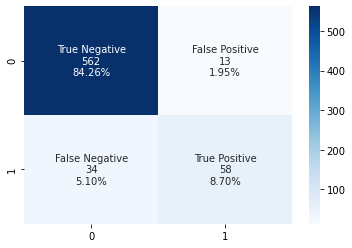

In [83]:
confusion_tree=confusion_matrix(y_test,  best_tuned_clf.predict(X_test))
print("\nconfusion matrix for tree(max_depth 4) after upsamling:\n{}".format(confusion_tree))

group_names = ["True Negative","False Positive","False Negative","True Positive"]
group_counts = ["{0:0.0f}".format(value) for value in
                confusion_tree.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     confusion_tree.flatten()/np.sum(confusion_tree)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns_plot = sns.heatmap(confusion_tree, annot=labels, fmt="", cmap='Blues')

# Featuring and Tuning Hyperparameters

In [84]:
X_train = X_train[[col[0] for col in importances[:5]]]
X_valid = X_valid[[col[0] for col in importances[:5]]]

In [85]:
df_classifier = DecisionTreeClassifier(random_state=5)

params_DT = {'criterion': ['gini', 'entropy'],
                  'splitter': ['best', 'random'],
                  'max_depth': [1, 2, 3, 4, 5, 6, 7, 8],
                  'max_features': [1, 2, 3, 4, 5 ,6],
                 'min_samples_split': [2, 3, 4]}

gs_DT = GridSearchCV(estimator=df_classifier, 
                     param_grid=params_DT, 
                     cv=cv_method,
                     n_jobs=-1,
                     verbose=1, 
                     scoring='accuracy')

gs_DT.fit(X_train, y_train);

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Fitting 30 folds for each of 576 candidates, totalling 17280 fits


[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 2536 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 10536 tasks      | elapsed:    7.9s
[Parallel(n_jobs=-1)]: Done 17280 out of 17280 | elapsed:   13.3s finished


In [86]:
bestcut_clf = gs_DT.best_estimator_

In [87]:
print(accuracy_score(y_valid, bestcut_clf.predict(X_valid)))

0.9119850187265918


In [88]:
X_test_cut = X_test[[col[0] for col in importances[:5]]]
print(classification_report(y_test, bestcut_clf.predict(X_test_cut)))

              precision    recall  f1-score   support

           0       0.93      0.96      0.95       575
           1       0.71      0.58      0.63        92

    accuracy                           0.91       667
   macro avg       0.82      0.77      0.79       667
weighted avg       0.90      0.91      0.90       667




confusion matrix for tree(max_depth 4) after upsamling:
[[553  22]
 [ 39  53]]


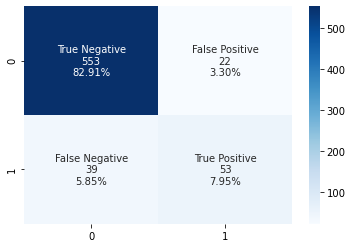

In [89]:
confusion_tree=confusion_matrix(y_test,  bestcut_clf.predict(X_test_cut))
print("\nconfusion matrix for tree(max_depth 4) after upsamling:\n{}".format(confusion_tree))

group_names = ["True Negative","False Positive","False Negative","True Positive"]
group_counts = ["{0:0.0f}".format(value) for value in
                confusion_tree.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     confusion_tree.flatten()/np.sum(confusion_tree)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns_plot = sns.heatmap(confusion_tree, annot=labels, fmt="", cmap='Blues')